In [1]:
#导入相应包
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.linalg.misc import norm

In [2]:
#读取训练数据
train_feature,train_label=load_svmlight_file('a9a')
train_feature = train_feature.todense()
train_label = np.asmatrix(train_label)
#读取测试数据
test_feature,test_label = load_svmlight_file('a9a.t')
test_feature = test_feature.todense()
test_label = np.asmatrix(test_label) #(1, 16281)



In [3]:
#向矩阵中加入偏执项的函数
def add_bias(matrix,bias):    
    bias = []
    #构造偏执项list
    for i in range(matrix.shape[0]):
        bias.append(1)
    #向矩阵中加入一列偏执项
    matrix = np.column_stack((matrix,bias))
    return matrix

#在特征集合中加入偏执项
train_feature = add_bias(train_feature,1)
test_feature = add_bias(test_feature,0) #测试集最后一维缺失了全0列
test_feature = add_bias(test_feature,1)

In [4]:
#构造并初始化系数矩阵
w = np.random.random(size=(1,train_feature.shape[1]))

In [5]:
#求取SVM一个batch的梯度
# w 表示系数矩阵
# x 表示一个batch矩阵
# y 表示这个batch的label
def get_gradient(x,y,w,C):
    gradient = 0
    for j in range(x.shape[0]):
        if 1 -  y[0,j]*( np.dot( x[j], np.transpose(w) ) ) >= 0 :
            gradient = gradient - y[0,j]*(x[j])

    gradient = gradient*C
    gradient = gradient+w
    gradient = gradient/x.shape[0]
    


    return gradient


In [6]:
#求取SVM的loss函数值
# x 表示所有样本及其特征
# y 表示这些样本的label
# w 表示系数矩阵

def svm_loss(x,y,w,C):
    
    loss = 0
    for j in range(x.shape[0]):
        loss = loss +  max(0,1 - y[0,j]*( np.dot(x[j], np.transpose(w))[0,0] ) )
    loss = loss*C
    loss = loss + ((norm(w))**2)/2
    loss = loss/x.shape[0]
    
    return loss

In [7]:
#求系数矩阵倒数的函数
def inverse_weight(matrix):
    for i in range(matrix.shape[1]):
        matrix[0,i] = 1/matrix[0,i]
    return matrix

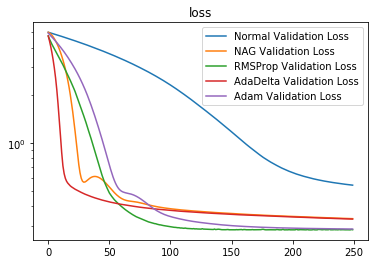

In [8]:
def SGD(x,y,x_val,y_val,w,gama,learning_rate,maxiterations,C):
    
    #定义迭代次数和不同优化方法的loss值
    iteration_time = [] #迭代次数
    loss_normal = [] #一般方法的loss值
    loss_NAG = [] #NAG的loss值
    loss_RMSProp = [] #RMSProp的loss值
    loss_AdaDelta = [] #AdaDelta的loss值
    loss_Adam = [] #Adam的loss值
    
    #定义不同优化方法对应的系数矩阵
    w_normal = w
    w_NAG = w
    w_RMSProp = w
    w_AdaDelta = w
    w_Adam = w
    
    #各优化方法的初始参数
    #NAG
    v_NAG = 0
    #RMSProp
    G_RMSProp = 0
    #AdaDelta
    G_AdaDelta = 0
    Delta = 0
    #Adam
    m_adam = 0
    beta = 0.9
    gama_adam = 0.99
    G_Adam = 0
    
    #进行迭代计算
    for i in range(0,maxiterations):
        
        #生成随机数，随机数的范围在x.shape[0]-1的范围内，表示生成的batch的大小
        batch_size =  int(x.shape[0]*0.1)           
        x_batch = 0
        y_batch = []
        for k in range(batch_size):
            randnum = random.randint(0,x.shape[0]-1)
            
            y_batch.append(y[0,randnum])
            if k == 0:
                x_batch = x[randnum]
            else:
                x_batch = np.vstack((x_batch,x[randnum]))
                
        y_batch = np.asmatrix(y_batch)
        

        
                  
        #求梯度
        #一般方法
        normal_gradient = get_gradient(x_batch,y_batch,w_normal,C) 
        #NAG
        NAG_gradient = get_gradient(x_batch,y_batch,w_NAG-gama*v_NAG,C)
        #RMSProp
        RMSProp_gradient = get_gradient(x_batch,y_batch,w_RMSProp,C)
        #AdaDelta
        AdaDelta_gradient = get_gradient(x_batch,y_batch,w_AdaDelta,C)
        #Adam
        Adam_gradient = get_gradient(x_batch,y_batch,w_Adam,C)
        
        
        
        #使用不同的梯度优化算法对梯度进行优化
        #一般方法
        w_normal = w_normal - learning_rate*normal_gradient     
        #NAG
        v_NAG = gama*v_NAG + learning_rate*NAG_gradient
        w_NAG = w_NAG - v_NAG
        
        
        #RMSProp
        G_RMSProp = gama*G_RMSProp + np.multiply(RMSProp_gradient,RMSProp_gradient )*(1-gama)
        w_RMSProp = w_RMSProp - np.multiply( inverse_weight( np.power(G_RMSProp+ 10**(-8),0.5) ) * learning_rate , RMSProp_gradient )
        
        #AdaDelta
        G_AdaDelta = gama*G_AdaDelta + np.multiply(AdaDelta_gradient,AdaDelta_gradient)*(1-gama)
        delta_w =  - np.multiply( np.multiply( np.power( Delta+10**(-1) ,0.5) , np.power(G_AdaDelta+10**(-1),0.5) ) , AdaDelta_gradient)
        w_AdaDelta = w_AdaDelta + delta_w
        Delta = gama*Delta + np.multiply(delta_w,delta_w) * (1-gama)
        
        
        #Adam
        m_adam = beta*m_adam + (1-beta)*Adam_gradient
        G_Adam = gama_adam*G_Adam + np.multiply(Adam_gradient,Adam_gradient)*(1-gama_adam)
        alpha = learning_rate*(  (1-gama_adam**(i+1))**0.5  ) * ( 1/( 1-beta**(i+1) ) )
        w_Adam = w_Adam - alpha * np.multiply( m_adam , inverse_weight( np.power(G_Adam+10**(-8),0.5) ) )

        
        
        
        
        #依据不同优化方法求出对应loss函数的结果,并进行记录
        
        #记录迭代次数
        iteration_time.append(i)
        
        #记录使用一般方法更新梯度的loss
        loss_normal.append(svm_loss(x_val,y_val,w_normal,C))
        
        #记录使用NAG更新梯度的loss
        loss_NAG.append(svm_loss(x_val,y_val,w_NAG,C))
        
        #记录使用RMSProp更新梯度的loss
        loss_RMSProp.append(svm_loss(x_val,y_val,w_RMSProp,C))
        
        #记录使用AdaDelta更新梯度的loss
        loss_AdaDelta.append(svm_loss(x_val,y_val,w_AdaDelta,C)) 
        
        #记录使用Adam更新梯度的loss
        loss_Adam.append(svm_loss(x_val,y_val,w_Adam,C))
        
        
        
    #画出loss的图像
    plt.yscale('log')
    plt.plot(iteration_time, loss_normal , label='Normal Validation Loss')
    plt.plot(iteration_time, loss_NAG , label='NAG Validation Loss')
    plt.plot(iteration_time, loss_RMSProp , label='RMSProp Validation Loss')
    plt.plot(iteration_time, loss_AdaDelta , label='AdaDelta Validation Loss')
    plt.plot(iteration_time, loss_Adam , label='Adam Validation Loss')


    plt.title('loss')
    plt.legend()
    plt.show()
        
        
SGD(train_feature,train_label,test_feature,test_label,w,0.9,0.01,250,0.8)
        
        
    
    
    
